In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import math
from statistics import mean
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from datetime import date
import datetime
import holidays

import lightgbm as lgb

In [2]:
status = pd.read_csv('../../../status.csv')

In [3]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)

main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'predict']]

#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)

train = main_df[main_df['date'] >= '2013-10-01']
train = train[train['date'] < '2013-11-01']
train = train[train['station_id'] == 0] 

test = main_df[main_df['date'] >= '2013-11-01']
test = test[test['date'] < '2013-11-08']
test = test[test['station_id'] == 0] 

#predictは特徴量として必要ないため、削除
train = train.drop("predict",axis=1)
train_df = train 
train

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
720,2013-10-01 00:00:00,0,0,16.0,0,0,0,0,0,1,0
721,2013-10-01 01:00:00,1,0,14.0,0,0,0,0,0,1,0
722,2013-10-01 02:00:00,2,0,14.0,0,0,0,0,0,1,0
723,2013-10-01 03:00:00,3,0,14.0,0,0,0,0,0,1,0
724,2013-10-01 04:00:00,4,0,14.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,1,0,0,0


In [4]:
#predictは特徴量として必要ないため、削除
train_week_X  = train.drop("station_id",axis=1)
train_week_X = train_week_X.drop("date",axis=1)

train_week_X = train_week_X.drop('bikes_available', axis = 1)
train_week_y = train['bikes_available']

In [5]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)
#valid_lightgbm_set = lgb.Dataset(valid_week_X, valid_week_y)

In [6]:
params = {
    "objective" : "regression",
    "metric" : "rmse",
#    "num_leaves": 200,
#    "learning_rate": 0.01,
#    "random_state" : 1,
    "verbose" : -1
}

In [7]:
lgb_model = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 300,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.84867
[10]	training's rmse: 2.62423
[15]	training's rmse: 2.53322
[20]	training's rmse: 2.49532
[25]	training's rmse: 2.47638
[30]	training's rmse: 2.46465
[35]	training's rmse: 2.45841
[40]	training's rmse: 2.45371
[45]	training's rmse: 2.44997
[50]	training's rmse: 2.44735
[55]	training's rmse: 2.44494
[60]	training's rmse: 2.44307
[65]	training's rmse: 2.44208
[70]	training's rmse: 2.44116
[75]	training's rmse: 2.44027
[80]	training's rmse: 2.4395
[85]	training's rmse: 2.43882
[90]	training's rmse: 2.43822
[95]	training's rmse: 2.43775
[100]	training's rmse: 2.43717
[105]	training's rmse: 2.43662
[110]	training's rmse: 2.43632
[115]	training's rmse: 2.43599
[120]	training's rmse: 2.43566
[125]	training's rmse: 2.43539
[130]	training's rmse: 2.43516
[135]	training's rmse: 2.43483
[140]	training's rmse: 2.43445
[145]	training's rmse: 2.4342
[150]	training's rmse: 2.43393
[155]	training's rmse: 2.43369


In [8]:
pred_lightgbn_train = lgb_model.predict(train_week_X)
#pred_lightgbm_test = lgb_model.predict(test_week_X)

In [9]:
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

train_visualization_lightgbm['predict'] = pred_lightgbn_train

train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
train_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,date_hour
720,720,2013,10,1,0,0,16.0,17.948238,2013-10-01 00:00:00,火曜日,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,17.447945,2013-10-01 01:00:00,火曜日,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,17.371982,2013-10-01 02:00:00,火曜日,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,17.424004,2013-10-01 03:00:00,火曜日,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,17.379850,2013-10-01 04:00:00,火曜日,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,19.015432,2013-10-31 19:00:00,木曜日,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,18.342271,2013-10-31 20:00:00,木曜日,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,17.806791,2013-10-31 21:00:00,木曜日,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,17.933501,2013-10-31 22:00:00,木曜日,2013-10-31 22:00:00


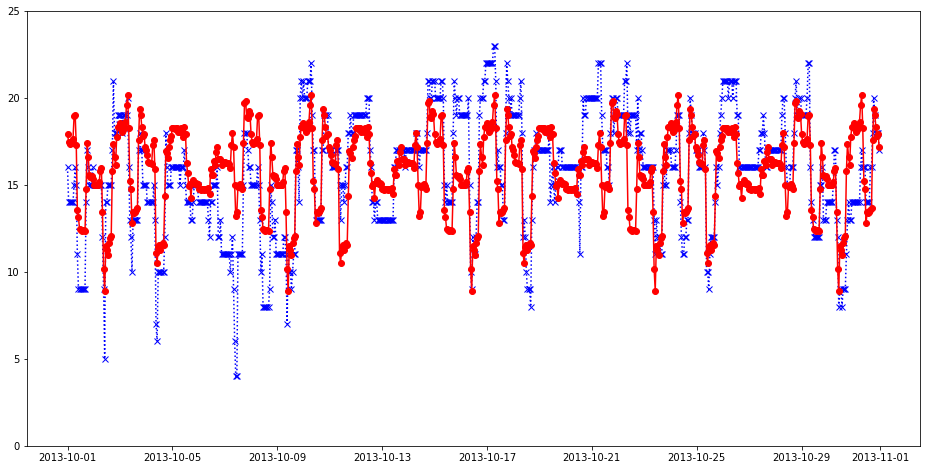

In [10]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [11]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

2.4301713981277704

In [12]:
#predictは特徴量として必要ないため、削除
test_week_X  = test.drop("station_id",axis=1)
test_week_X = test_week_X.drop("date",axis=1)
test_week_X = test_week_X.drop("predict",axis=1)

test_week_X = test_week_X.drop('bikes_available', axis = 1)
test_week_y = test['bikes_available']

In [13]:
pred_lightgbm_test = lgb_model.predict(test_week_X)

In [14]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

test_visualization_lightgbm['predict'] = pred_lightgbm_test

test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
test_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,date_hour
1464,1464,2013,11,1,0,0,17.0,16.994629,2013-11-01 00:00:00,金曜日,2013-11-01 00:00:00
1465,1465,2013,11,1,1,0,16.0,16.698638,2013-11-01 01:00:00,金曜日,2013-11-01 01:00:00
1466,1466,2013,11,1,2,0,16.0,16.306038,2013-11-01 02:00:00,金曜日,2013-11-01 02:00:00
1467,1467,2013,11,1,3,0,16.0,16.254047,2013-11-01 03:00:00,金曜日,2013-11-01 03:00:00
1468,1468,2013,11,1,4,0,16.0,16.275241,2013-11-01 04:00:00,金曜日,2013-11-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,19.015432,2013-11-07 19:00:00,木曜日,2013-11-07 19:00:00
1628,1628,2013,11,7,20,0,16.0,18.342271,2013-11-07 20:00:00,木曜日,2013-11-07 20:00:00
1629,1629,2013,11,7,21,0,16.0,17.806791,2013-11-07 21:00:00,木曜日,2013-11-07 21:00:00
1630,1630,2013,11,7,22,0,16.0,17.933501,2013-11-07 22:00:00,木曜日,2013-11-07 22:00:00


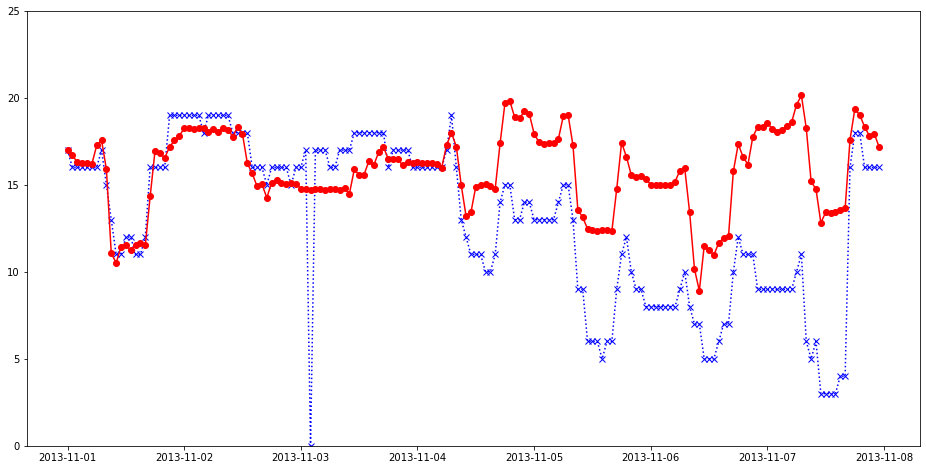

In [15]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [16]:
#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

4.850890247246163

In [17]:
#ここからlag変数を導入していく
#最初は24hour分

In [18]:
train_lag_set = main_df[main_df['date'] >= '2013-09-20']
train_lag_set = train_lag_set[train_lag_set['date'] < '2013-11-01']
train_lag_set = train_lag_set[train_lag_set['station_id'] == 0] 
train_lag_set = train_lag_set.set_index('date')
train_lag_set = train_lag_set['bikes_available']

test_lag_set = main_df[main_df['date'] >= '2013-10-21']
test_lag_set = test_lag_set[test_lag_set['date'] < '2013-11-01']
test_lag_set = test_lag_set[test_lag_set['station_id'] == 0] 
test_lag_set = test_lag_set.set_index('date')
test_lag_set = test_lag_set['bikes_available']

In [19]:
i = 1
while i < 25:
    row_name = "lag_" + str(i) + "hour"
    set = train_lag_set[264-i:1008-i]
    train_week_X[row_name] = set.values
    i += 1
i = 0

In [20]:
train_week_X

,hour,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日,lag_1hour,lag_2hour,...,lag_15hour,lag_16hour,lag_17hour,lag_18hour,lag_19hour,lag_20hour,lag_21hour,lag_22hour,lag_23hour,lag_24hour
720,0,0,0,0,0,0,1,0,16.0,16.0,...,14.0,18.0,18.0,18.0,17.0,17.0,17.0,17.0,18.0,18.0
721,1,0,0,0,0,0,1,0,16.0,16.0,...,12.0,14.0,18.0,18.0,18.0,17.0,17.0,17.0,17.0,18.0
722,2,0,0,0,0,0,1,0,14.0,16.0,...,11.0,12.0,14.0,18.0,18.0,18.0,17.0,17.0,17.0,17.0
723,3,0,0,0,0,0,1,0,14.0,14.0,...,12.0,11.0,12.0,14.0,18.0,18.0,18.0,17.0,17.0,17.0
724,4,0,0,0,0,0,1,0,14.0,14.0,...,12.0,12.0,11.0,12.0,14.0,18.0,18.0,18.0,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,19,0,0,0,1,0,0,0,20.0,18.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,13.0,13.0,14.0
1460,20,0,0,0,1,0,0,0,19.0,20.0,...,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,13.0,13.0
1461,21,0,0,0,1,0,0,0,18.0,19.0,...,16.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,13.0
1462,22,0,0,0,1,0,0,0,18.0,18.0,...,17.0,16.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0


In [21]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)

In [22]:
lgb_model_lag24 = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 300,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.25144
[10]	training's rmse: 1.6449
[15]	training's rmse: 1.32464
[20]	training's rmse: 1.15684
[25]	training's rmse: 1.05724
[30]	training's rmse: 0.983419
[35]	training's rmse: 0.922255
[40]	training's rmse: 0.861935
[45]	training's rmse: 0.815559
[50]	training's rmse: 0.769404
[55]	training's rmse: 0.729869
[60]	training's rmse: 0.699778
[65]	training's rmse: 0.670065
[70]	training's rmse: 0.641563
[75]	training's rmse: 0.612463
[80]	training's rmse: 0.586268
[85]	training's rmse: 0.564731
[90]	training's rmse: 0.543538
[95]	training's rmse: 0.523842
[100]	training's rmse: 0.505127
[105]	training's rmse: 0.48695
[110]	training's rmse: 0.470043
[115]	training's rmse: 0.453613
[120]	training's rmse: 0.439923
[125]	training's rmse: 0.425523
[130]	training's rmse: 0.411777
[135]	training's rmse: 0.39916
[140]	training's rmse: 0.387924
[145]	training's rmse: 0.37633
[150]	training's rmse: 0.365558
[155]	tr

In [23]:
pred_lightgbn_train24 = lgb_model_lag24.predict(train_week_X)
#pred_lightgbm_test = lgb_model.predict(test_week_X)

In [24]:
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

train_visualization_lightgbm['lightgbm_lag24_predict'] = pred_lightgbn_train24

train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
train_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,lightgbm_lag24_predict,date_hour
720,720,2013,10,1,0,0,16.0,0,2013-10-01 00:00:00,火曜日,15.898354,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,0,2013-10-01 01:00:00,火曜日,14.113857,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,0,2013-10-01 02:00:00,火曜日,13.965965,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,0,2013-10-01 03:00:00,火曜日,13.967241,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,0,2013-10-01 04:00:00,火曜日,13.969321,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,0,2013-10-31 19:00:00,木曜日,19.164387,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,0,2013-10-31 20:00:00,木曜日,17.969376,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,0,2013-10-31 21:00:00,木曜日,18.032045,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,0,2013-10-31 22:00:00,木曜日,17.810726,2013-10-31 22:00:00


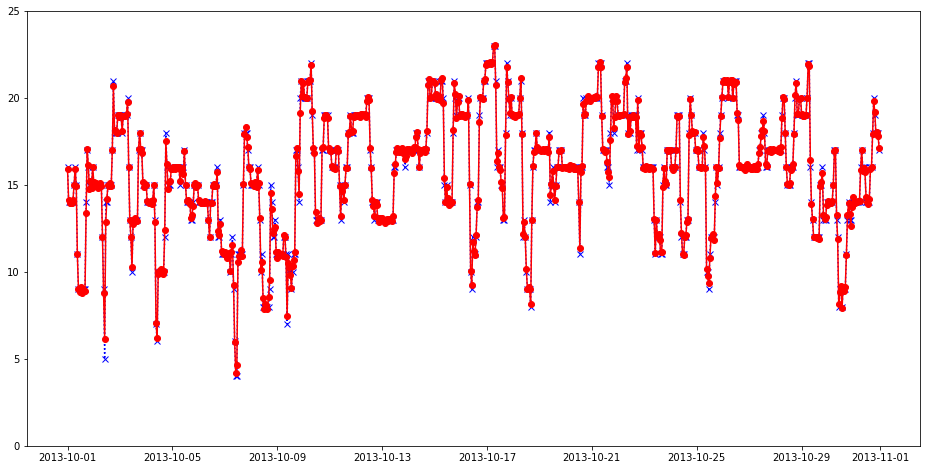

In [25]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lightgbm_lag24_predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [26]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['lightgbm_lag24_predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

0.1661091270446235

In [27]:
pred_lightgbm_test_lag = []
len(pred_lightgbm_test_lag)
i=0
while i < 168:
    test_week_X_line = test_week_X[i:i+1]
    
    lag = []
    for j in pred_lightgbm_test_lag:
        lag.insert(0, j)
        
    for k in range(24 - len(pred_lightgbm_test_lag)):
        lag.append(test_lag_set[263-k:264-k].values)
    s = 1
    while s < 25:
        row_name = "lag_" + str(s) + "hour"
        test_week_X_line[row_name] = lag[s-1]
        s += 1

    pred_lightgbm_test_lag_line = lgb_model_lag24.predict(test_week_X_line)
    pred_lightgbm_test_lag =np.append(pred_lightgbm_test_lag, pred_lightgbm_test_lag_line)
    i += 1

In [28]:
pred_lightgbm_test_lag

array([16.43717504, 15.50880231, 15.70652033, 15.67646247, 15.34088776,
       14.2372508 , 14.22054969, 13.16552784, 12.87191264, 11.75417187,
       11.02778532, 11.26826192, 11.54154364, 12.12104319, 11.78193088,
       11.74721418, 11.29637595, 13.82846773, 16.03209414, 16.05518134,
       15.83392292, 17.66368318, 18.61407246, 18.15586453, 18.55044648,
       18.82953086, 18.77742317, 18.32291668, 17.98695939, 17.92253512,
       18.54079806, 18.56804589, 17.7819159 , 16.76072504, 14.81594866,
       14.09490959, 14.39933125, 13.93283483, 13.85643312, 13.86509823,
       13.8531324 , 15.57831659, 15.7049584 , 16.66430214, 16.68274856,
       16.67971808, 15.4378857 , 14.58772008, 14.51802106, 14.37502907,
       13.25623144, 12.58345692, 12.82580464, 13.19055914, 13.12817063,
       13.31957937, 12.58656818, 11.37827644, 10.42431208, 10.95881476,
       11.55317263, 11.75617406, 12.39052826, 12.33517414, 12.26210823,
       14.49457745, 15.41226722, 14.97748738, 15.4398321 , 15.57

In [29]:
len(pred_lightgbm_test_lag)

168

In [30]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

test_visualization_lightgbm['lightgbm_lag24_predict'] = pred_lightgbm_test_lag

test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)


test_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,lightgbm_lag24_predict,date_hour
1464,1464,2013,11,1,0,0,17.0,0,2013-11-01 00:00:00,金曜日,16.437175,2013-11-01 00:00:00
1465,1465,2013,11,1,1,0,16.0,0,2013-11-01 01:00:00,金曜日,15.508802,2013-11-01 01:00:00
1466,1466,2013,11,1,2,0,16.0,0,2013-11-01 02:00:00,金曜日,15.706520,2013-11-01 02:00:00
1467,1467,2013,11,1,3,0,16.0,0,2013-11-01 03:00:00,金曜日,15.676462,2013-11-01 03:00:00
1468,1468,2013,11,1,4,0,16.0,0,2013-11-01 04:00:00,金曜日,15.340888,2013-11-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,0,2013-11-07 19:00:00,木曜日,12.165015,2013-11-07 19:00:00
1628,1628,2013,11,7,20,0,16.0,0,2013-11-07 20:00:00,木曜日,11.052484,2013-11-07 20:00:00
1629,1629,2013,11,7,21,0,16.0,0,2013-11-07 21:00:00,木曜日,11.704606,2013-11-07 21:00:00
1630,1630,2013,11,7,22,0,16.0,0,2013-11-07 22:00:00,木曜日,11.944255,2013-11-07 22:00:00


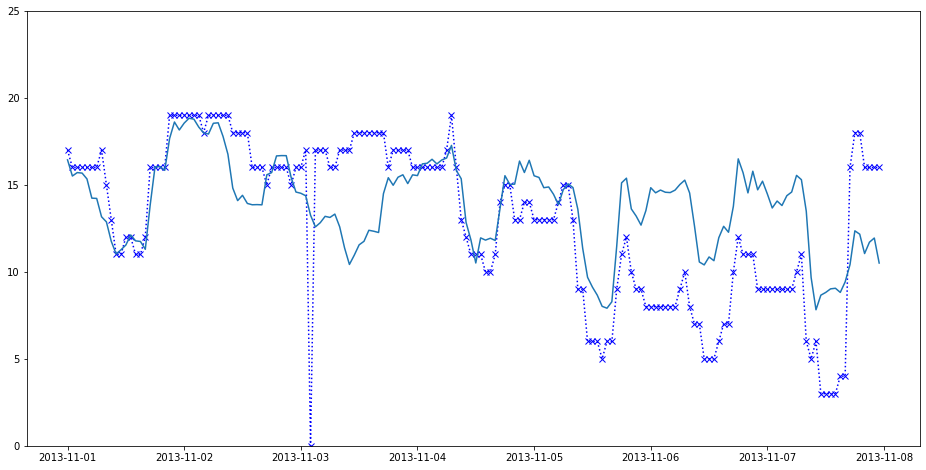

In [31]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag24_predict'])

In [32]:
test_visualization_lightgbm['predict'] = pred_lightgbm_test

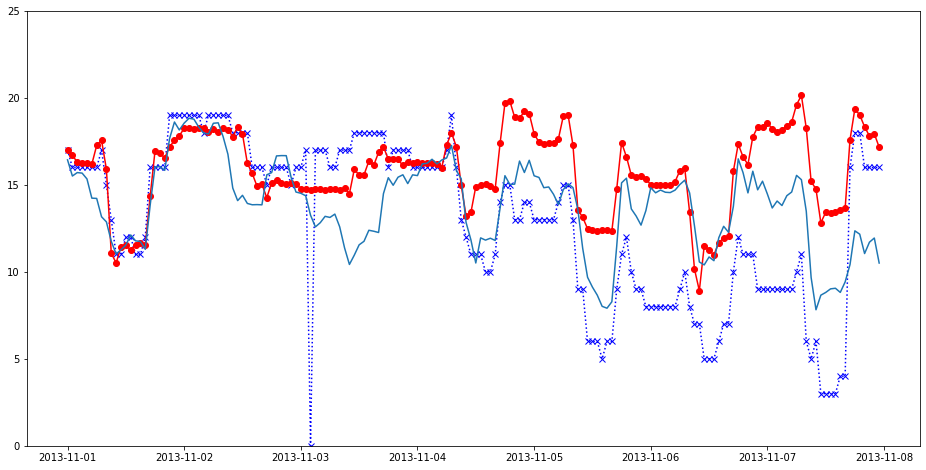

In [33]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag24_predict'])

In [34]:
#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['lightgbm_lag24_predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

3.7873300037042936

In [35]:
#次はlag48hour

In [36]:
i = 25
while i < 49:
    row_name = "lag_" + str(i) + "hour"
    set = train_lag_set[264-i:1008-i]
    train_week_X[row_name] = set.values
    i += 1
i = 0

In [37]:
train_week_X.dtypes

hour             int64
weekday_土曜日      uint8
weekday_日曜日      uint8
weekday_月曜日      uint8
weekday_木曜日      uint8
weekday_水曜日      uint8
weekday_火曜日      uint8
weekday_金曜日      uint8
lag_1hour      float64
lag_2hour      float64
lag_3hour      float64
lag_4hour      float64
lag_5hour      float64
lag_6hour      float64
lag_7hour      float64
lag_8hour      float64
lag_9hour      float64
lag_10hour     float64
lag_11hour     float64
lag_12hour     float64
lag_13hour     float64
lag_14hour     float64
lag_15hour     float64
lag_16hour     float64
lag_17hour     float64
lag_18hour     float64
lag_19hour     float64
lag_20hour     float64
lag_21hour     float64
lag_22hour     float64
lag_23hour     float64
lag_24hour     float64
lag_25hour     float64
lag_26hour     float64
lag_27hour     float64
lag_28hour     float64
lag_29hour     float64
lag_30hour     float64
lag_31hour     float64
lag_32hour     float64
lag_33hour     float64
lag_34hour     float64
lag_35hour     float64
lag_36hour 

In [38]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)
lgb_model_lag48 = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 300,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.24685
[10]	training's rmse: 1.64199
[15]	training's rmse: 1.31155
[20]	training's rmse: 1.13091
[25]	training's rmse: 1.01162
[30]	training's rmse: 0.935024
[35]	training's rmse: 0.851316
[40]	training's rmse: 0.787669
[45]	training's rmse: 0.730985
[50]	training's rmse: 0.681135
[55]	training's rmse: 0.640171
[60]	training's rmse: 0.601673
[65]	training's rmse: 0.567523
[70]	training's rmse: 0.537713
[75]	training's rmse: 0.509845
[80]	training's rmse: 0.482985
[85]	training's rmse: 0.45876
[90]	training's rmse: 0.434937
[95]	training's rmse: 0.412129
[100]	training's rmse: 0.391884
[105]	training's rmse: 0.374641
[110]	training's rmse: 0.359423
[115]	training's rmse: 0.343831
[120]	training's rmse: 0.328719
[125]	training's rmse: 0.315641
[130]	training's rmse: 0.302551
[135]	training's rmse: 0.289878
[140]	training's rmse: 0.279004
[145]	training's rmse: 0.266846
[150]	training's rmse: 0.257769
[155]

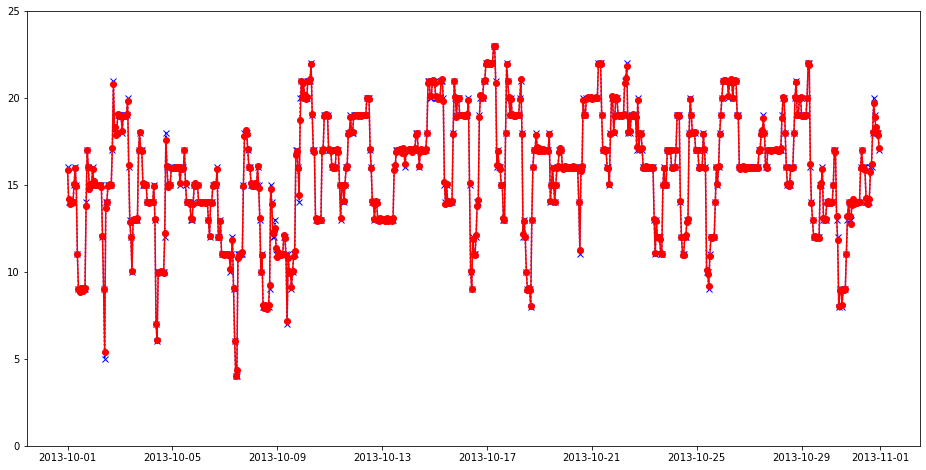

In [39]:
pred_lightgbn_train48 = lgb_model_lag48.predict(train_week_X)

train_visualization_lightgbm['lightgbm_lag48_predict'] = pred_lightgbn_train48

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lightgbm_lag48_predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [40]:
#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['lightgbm_lag48_predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

0.09934634628463523

In [41]:
pred_lightgbm_test_lag = []
len(pred_lightgbm_test_lag)
i=0
while i < 168:
    test_week_X_line = test_week_X[i:i+1]
    
    lag = []
    for j in pred_lightgbm_test_lag:
        lag.insert(0, j)
        
    for k in range(48 - len(pred_lightgbm_test_lag)):
        lag.append(test_lag_set[263-k:264-k].values)
    s = 1
    while s < 49:
        row_name = "lag_" + str(s) + "hour"
        test_week_X_line[row_name] = lag[s-1]
        s += 1

    pred_lightgbm_test_lag_line = lgb_model_lag48.predict(test_week_X_line)
    pred_lightgbm_test_lag =np.append(pred_lightgbm_test_lag, pred_lightgbm_test_lag_line)
    i += 1

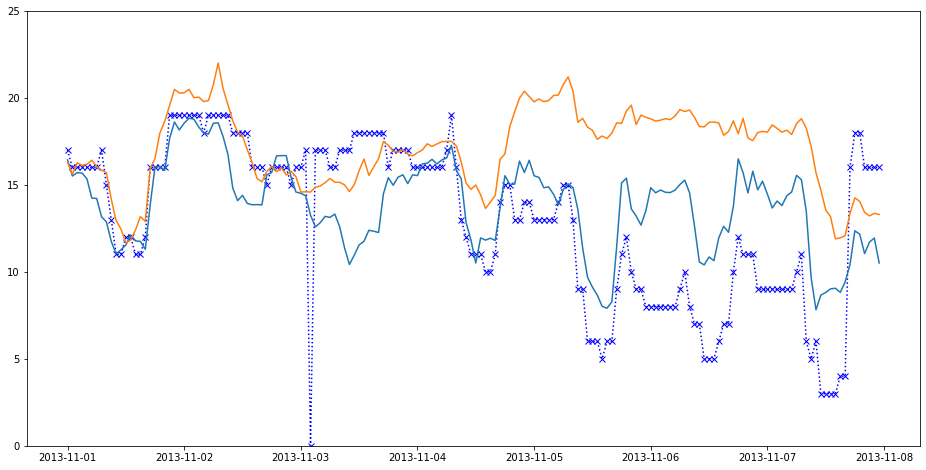

In [42]:
test_visualization_lightgbm['lightgbm_lag48_predict'] = pred_lightgbm_test_lag

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag24_predict'])
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag48_predict'])

In [43]:
#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['lightgbm_lag48_predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

6.4641573856633725

In [44]:
#次はlag72hour

In [45]:
i = 49
while i < 73:
    row_name = "lag_" + str(i) + "hour"
    set = train_lag_set[264-i:1008-i]
    train_week_X[row_name] = set.values
    i += 1
i = 0

In [46]:
train_week_X.dtypes

hour             int64
weekday_土曜日      uint8
weekday_日曜日      uint8
weekday_月曜日      uint8
weekday_木曜日      uint8
                ...   
lag_68hour     float64
lag_69hour     float64
lag_70hour     float64
lag_71hour     float64
lag_72hour     float64
Length: 80, dtype: object

In [47]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)
lgb_model_lag72 = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 300,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.24425
[10]	training's rmse: 1.63631
[15]	training's rmse: 1.29649
[20]	training's rmse: 1.11125
[25]	training's rmse: 0.987584
[30]	training's rmse: 0.901837
[35]	training's rmse: 0.825325
[40]	training's rmse: 0.757795
[45]	training's rmse: 0.698583
[50]	training's rmse: 0.647682
[55]	training's rmse: 0.600684
[60]	training's rmse: 0.5616
[65]	training's rmse: 0.526295
[70]	training's rmse: 0.494979
[75]	training's rmse: 0.467937
[80]	training's rmse: 0.442949
[85]	training's rmse: 0.420154
[90]	training's rmse: 0.396377
[95]	training's rmse: 0.374371
[100]	training's rmse: 0.354303
[105]	training's rmse: 0.33646
[110]	training's rmse: 0.31893
[115]	training's rmse: 0.303398
[120]	training's rmse: 0.289216
[125]	training's rmse: 0.275257
[130]	training's rmse: 0.263203
[135]	training's rmse: 0.252113
[140]	training's rmse: 0.241276
[145]	training's rmse: 0.231488
[150]	training's rmse: 0.22141
[155]	tr

0.07787979805716067

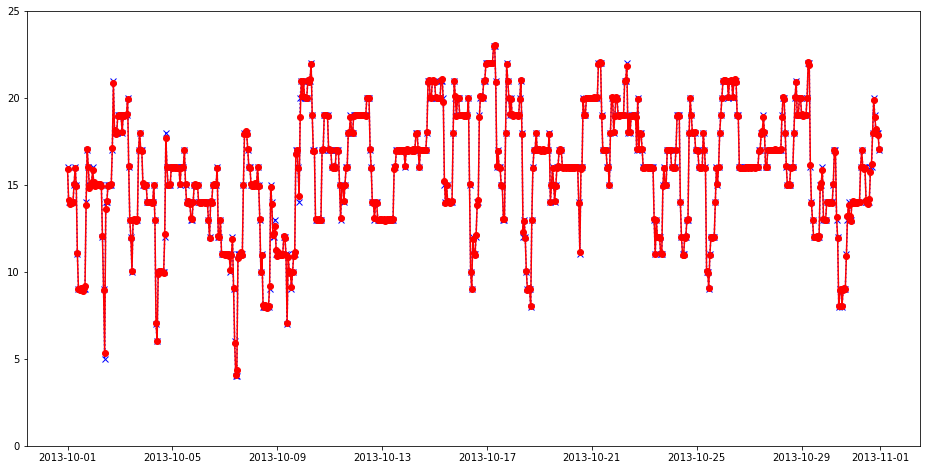

In [48]:
pred_lightgbn_train72 = lgb_model_lag72.predict(train_week_X)

train_visualization_lightgbm['lightgbm_lag72_predict'] = pred_lightgbn_train72

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['lightgbm_lag72_predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

#trainデータのrmse
mean_squared_error(train_visualization_lightgbm['lightgbm_lag72_predict'].values, train_visualization_lightgbm['bikes_available'].values, squared=False)

In [49]:
pred_lightgbm_test_lag = []
len(pred_lightgbm_test_lag)
i=0
while i < 168:
    test_week_X_line = test_week_X[i:i+1]
    
    lag = []
    for j in pred_lightgbm_test_lag:
        lag.insert(0, j)
        
    for k in range(72 - len(pred_lightgbm_test_lag)):
        lag.append(test_lag_set[263-k:264-k].values)
    s = 1
    while s < 73:
        row_name = "lag_" + str(s) + "hour"
        test_week_X_line[row_name] = lag[s-1]
        s += 1

    pred_lightgbm_test_lag_line = lgb_model_lag72.predict(test_week_X_line)
    pred_lightgbm_test_lag =np.append(pred_lightgbm_test_lag, pred_lightgbm_test_lag_line)
    i += 1

4.927467153993042

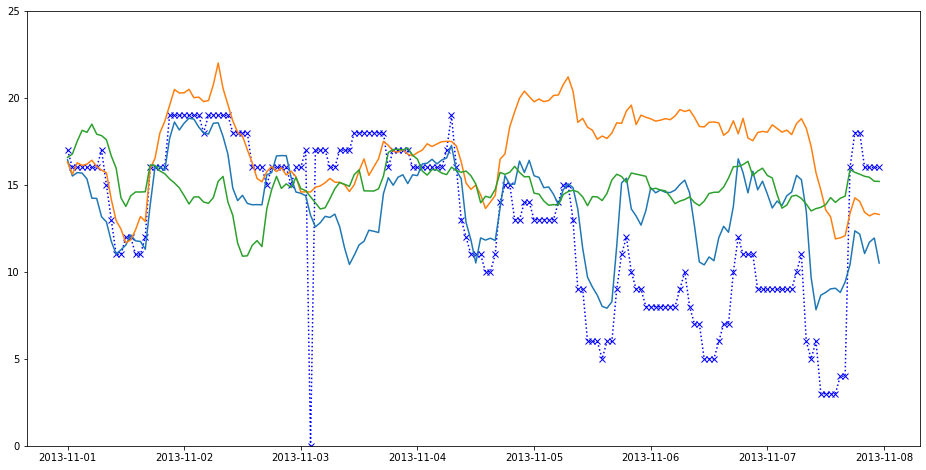

In [50]:
test_visualization_lightgbm['lightgbm_lag72_predict'] = pred_lightgbm_test_lag

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag24_predict'])
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag48_predict'])
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag72_predict'])


#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['lightgbm_lag72_predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

4.927467153993042

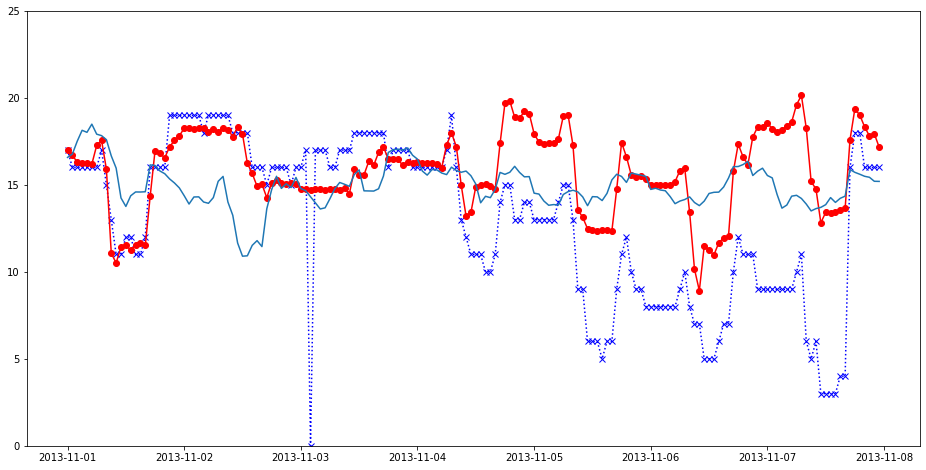

In [61]:
test_visualization_lightgbm['lightgbm_lag72_predict'] = pred_lightgbm_test_lag

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')
#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag24_predict'])
#plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag48_predict'])
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['lightgbm_lag72_predict'])


#trainデータのrmse
mean_squared_error(test_visualization_lightgbm['lightgbm_lag72_predict'].values, test_visualization_lightgbm['bikes_available'].values, squared=False)

In [52]:
#RandomForest_lag

In [53]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(train_week_X, train_week_y)

RandomForestRegressor(max_depth=15, random_state=0)

In [54]:
#trainデータに対して予測
RF_train_predict = regr.predict(train_week_X)
RF_train_predict

array([15.61028912, 14.67      , 13.94091889, 14.03213259, 14.11317313,
       14.16219752, 14.78165698, 15.28158108, 14.91      , 11.89894737,
        9.08      ,  8.83      ,  9.1       ,  8.92      ,  9.04      ,
        9.04      ,  9.25      , 12.92      , 16.3005    , 16.45792328,
       15.14      , 15.04179187, 15.12129544, 15.63283107, 15.14330039,
       15.06210291, 15.02084057, 14.9496739 , 15.00050724, 14.89437058,
       14.94517058, 14.85517058, 12.73530926,  9.08      ,  6.37      ,
       11.68      , 14.29336467, 14.74349695, 14.94779272, 15.0645725 ,
       15.20512513, 16.45185001, 19.51853807, 18.73      , 17.86      ,
       18.12      , 18.66984012, 18.99984012, 19.00998636, 18.89927185,
       18.33943173, 18.37015858, 18.79247219, 19.01128818, 19.088912  ,
       19.0983699 , 16.95      , 13.59576193, 11.97      , 10.87      ,
       12.11      , 12.85954545, 12.99989028, 13.03989028, 13.36034483,
       16.16      , 17.68964912, 17.73370153, 16.89348155, 15.61

In [55]:
train_visualization_lightgbm['RF_train_predict'] = RF_train_predict

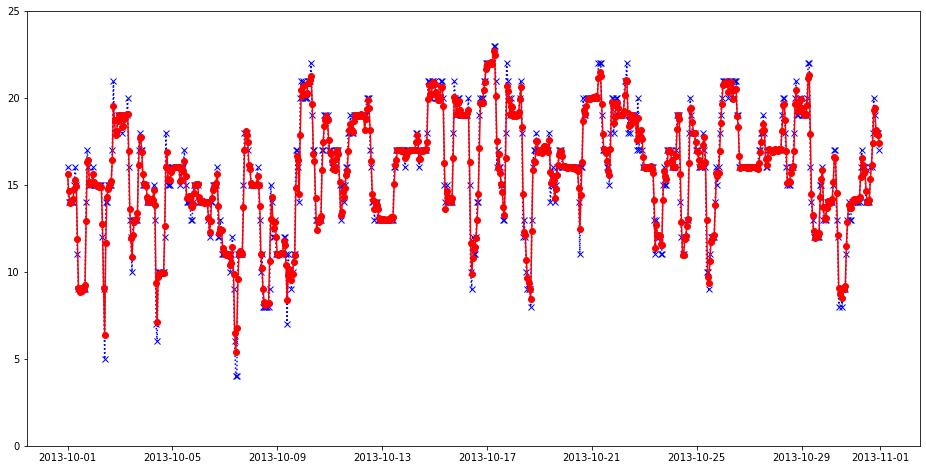

In [56]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['RF_train_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [62]:
pred_rf_test_lag = []
len(pred_rf_test_lag)

0

In [58]:
i=j=k=0

In [59]:
for i in range(168):
    test_week_X_1 = test_week_X[i:i+1]
    
    lag = []
    for j in pred_rf_test_lag:
        lag.insert(0, j)
        
    for k in range(24 - len(pred_rf_test_lag)):
        lag.append(test_lag_set[23-k:24-k].values)
    
    test_week_X_1['lag_1hour'] = lag[0]
    test_week_X_1['lag_2hour'] = lag[1]
    test_week_X_1['lag_3hour'] = lag[2]
    test_week_X_1['lag_4hour'] = lag[3]
    test_week_X_1['lag_5hour'] = lag[4]
    test_week_X_1['lag_6hour'] = lag[5]
    test_week_X_1['lag_7hour'] = lag[6]
    test_week_X_1['lag_8hour'] = lag[7]
    test_week_X_1['lag_9hour'] = lag[8]
    test_week_X_1['lag_10hour'] = lag[9]
    test_week_X_1['lag_11hour'] = lag[10]
    test_week_X_1['lag_12hour'] = lag[11]
    test_week_X_1['lag_13hour'] = lag[12]
    test_week_X_1['lag_14hour'] = lag[13]
    test_week_X_1['lag_15hour'] = lag[14]
    test_week_X_1['lag_16hour'] = lag[15]
    test_week_X_1['lag_17hour'] = lag[16]
    test_week_X_1['lag_18hour'] = lag[17]
    test_week_X_1['lag_19hour'] = lag[18]
    test_week_X_1['lag_20hour'] = lag[19]
    test_week_X_1['lag_21hour'] = lag[20]
    test_week_X_1['lag_22hour'] = lag[21]
    test_week_X_1['lag_23hour'] = lag[22]
    test_week_X_1['lag_24hour'] = lag[23]
    
    pred_rf_test_lag_row = regr.predict(test_week_X_1)
    pred_rf_test_lag =np.append(pred_rf_test_lag, pred_rf_test_lag_row)

ValueError: X has 32 features, but DecisionTreeRegressor is expecting 80 features as input.

In [ ]:
pred_rf_test_lag

In [ ]:
test_visualization_lightgbm['rf_predict'] = pred_rf_test_lag

In [ ]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['rf_predict'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [ ]:
test_week_X

In [ ]:
test_lag_set

In [ ]:
#深さを変えてみる

In [ ]:
regr_2 = RandomForestRegressor(max_depth=35, random_state=0)
regr_2.fit(train_week_X, train_week_y)

In [ ]:
#trainデータに対して予測
RF_train_predict = regr_2.predict(train_week_X)

train_visualization_lightgbm['RF_train_predict_2'] = RF_train_predict

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['RF_train_predict_2'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [ ]:
pred_rf_test_lag = []
len(pred_rf_test_lag)

In [ ]:
for i in range(168):
    test_week_X_1 = test_week_X[i:i+1]
    
    lag = []
    for j in pred_rf_test_lag:
        lag.insert(0, j)
        
    for k in range(24 - len(pred_rf_test_lag)):
        lag.append(test_lag_set[23-k:24-k].values)
    
    test_week_X_1['lag_1hour'] = lag[0]
    test_week_X_1['lag_2hour'] = lag[1]
    test_week_X_1['lag_3hour'] = lag[2]
    test_week_X_1['lag_4hour'] = lag[3]
    test_week_X_1['lag_5hour'] = lag[4]
    test_week_X_1['lag_6hour'] = lag[5]
    test_week_X_1['lag_7hour'] = lag[6]
    test_week_X_1['lag_8hour'] = lag[7]
    test_week_X_1['lag_9hour'] = lag[8]
    test_week_X_1['lag_10hour'] = lag[9]
    test_week_X_1['lag_11hour'] = lag[10]
    test_week_X_1['lag_12hour'] = lag[11]
    test_week_X_1['lag_13hour'] = lag[12]
    test_week_X_1['lag_14hour'] = lag[13]
    test_week_X_1['lag_15hour'] = lag[14]
    test_week_X_1['lag_16hour'] = lag[15]
    test_week_X_1['lag_17hour'] = lag[16]
    test_week_X_1['lag_18hour'] = lag[17]
    test_week_X_1['lag_19hour'] = lag[18]
    test_week_X_1['lag_20hour'] = lag[19]
    test_week_X_1['lag_21hour'] = lag[20]
    test_week_X_1['lag_22hour'] = lag[21]
    test_week_X_1['lag_23hour'] = lag[22]
    test_week_X_1['lag_24hour'] = lag[23]
    
    pred_rf_test_lag_row = regr_2.predict(test_week_X_1)
    pred_rf_test_lag =np.append(pred_rf_test_lag, pred_rf_test_lag_row)

In [ ]:
test_visualization_lightgbm['rf_predict_2'] = pred_rf_test_lag

plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['rf_predict'].values, color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['rf_predict_2'].values, color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [ ]:
train_week_X

In [ ]:
test_week_X_1

In [ ]:
train_week_X.dtypes